In [1]:
## over-parametrized setting

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math


In [2]:
# Set random seed for reproducibility.
#np.random.seed(13)

######################################
# Helper Functions 
######################################
def clip_C(val, C):
    return np.clip(val, -C, C)

def project_matrix(M, radius, dp_enabled=True):
    if dp_enabled:
        fro_norm = np.linalg.norm(M, 'fro')
        if fro_norm > radius:
            return (radius / fro_norm) * M
        return M
    else:
        return M

def sample_unit_sphere(d):
    x = np.random.randn(d)
    return x / np.linalg.norm(x)

def sample_L_unit_sphere(d, L):
    X = np.random.randn(L, d)
    X_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / X_norms

def compute_Ztilde(x_query, xs, ys, L, G, C, dp_enabled=True):
    """
    Compute the summary statistic Z_tilde for a query point.

    Z_tilde = Pi_G((1/L) * outer(x_query, sum_i clip_C(ys[i]) * xs[i]))

    Parameters:
        x_query (np.ndarray): Query vector of shape (D,).
        xs (np.ndarray): Data vectors of shape (L, D).
        ys (np.ndarray): Labels of shape (L,).
        L (int): Number of samples.
        G (float): Frobenius norm clipping threshold.
        C (float): Label clipping threshold.
        dp_enabled (bool): Whether to apply clipping and projection.

    Returns:
        np.ndarray: Projected matrix Z_tilde of shape (D, D).
    """
    ys_clipped = np.clip(ys, -C, C) if dp_enabled else ys
    v = np.sum(ys_clipped[:, None] * xs, axis=0)
    Z = (1.0 / L) * np.outer(x_query, v)
    return project_matrix(Z, G, dp_enabled)


def compute_Ztilde_vectorized(xq, xs, ys, L, G, C, dp_enabled=True):
    """
    Vectorized computation of the summary statistic for a batch of prompts.
      xq: shape (N, D)
      xs: shape (N, L, D)
      ys: shape (N, L)
    Returns:
      Z: shape (N, D, D)
    """
    if dp_enabled:
        ys_clipped = np.clip(ys, -C, C)
    else:
        ys_clipped = ys
    # Compute v for each prompt: shape (N, D)
    v = np.sum(ys_clipped[..., None] * xs, axis=1)
    # Compute outer product for each prompt: shape (N, D, D)
    Z = (1.0 / L) * (xq[:, :, None] * v[:, None, :])
    if dp_enabled:
        fro_norm = np.linalg.norm(Z, axis=(1,2))
        scaling = np.where(fro_norm > G, G / fro_norm, 1.0)
        Z = Z * scaling[:, None, None]
    return Z



def dp_noise(shape, noise_std):
    return np.random.normal(0, noise_std, size=shape)

def generate_prompt(D, L):
    xs = sample_L_unit_sphere(D, L)
    x_query = sample_unit_sphere(D)
    w_true = np.random.randn(D)
    ys = xs @ w_true
    y_query = x_query @ w_true
    return xs, x_query, ys, y_query

def build_dataset(N, D, L):
    xs_all, xq_all, ys_all, yq_all = [], [], [], []
    for _ in range(N):
        xs, xq, ys, yq = generate_prompt(D, L)
        xs_all.append(xs)
        xq_all.append(xq)
        ys_all.append(ys)
        yq_all.append(yq)
    return np.array(xs_all), np.array(xq_all), np.array(ys_all), np.array(yq_all)



In [3]:
def train_algorithm2(xs_all, xq_all, ys_all, yq_all,
                     D, N, L,
                     C, R, G, lam, eta0, T, epsilon, delta,
                     sigma_multiplier, dp_enabled):
    """
    Trains "Algorithm 2" from the paper.

    Parameters:
        xs_all, xq_all, ys_all, yq_all: dataset tensors
        D (int): Dimensionality
        N (int): Number of prompts
        L (int): Number of training tokens per prompt
        C, R, G, lam, eta0: model hyperparameters
        T (int): Number of training steps
        epsilon, delta: DP parameters
        sigma_multiplier (float): scales DP noise
        dp_enabled (bool): whether DP is active

    Returns:
        train_losses (list): MSE per iteration
        Gamma (np.ndarray): final (D, D) matrix
        Ztilde_ls (np.ndarray): summary matrices (N, D, D)
        noise_std (float): DP noise standard deviation
    """

    # Precompute Z_tilde matrices
    Ztilde_ls = np.array([
        compute_Ztilde(xq_all[k], xs_all[k], ys_all[k], L, G, C, dp_enabled)
        for k in range(N)
    ])  # shape (N, D, D)

    # Differential Privacy noise scale
    if dp_enabled:
        sigma_lower_bound = 2.0 * G * (C + R * G)
        sigma = sigma_lower_bound * sigma_multiplier
        denom = (epsilon**2) * (N**2)
        noise_variance = (2.0 * (eta0**2) * (T**2) * (sigma**2) * np.log(1.25 * T / delta)) / denom
        noise_std = np.sqrt(noise_variance)
    else:
        noise_std = 0.0

    # Initialize Gamma
    Gamma = np.random.randn(D, D) * 0.1
    Gamma = project_matrix(Gamma, R, dp_enabled)

    train_losses = []

    for t in tqdm(range(T), desc="Training", ncols=100, position=0):
        # Predict y for each prompt
        y_preds = np.einsum('nij,ij->n', Ztilde_ls, Gamma)  # shape (N,)
        y_clips = np.clip(yq_all, -C, C) if dp_enabled else yq_all
        errs = y_preds - y_clips

        # Gradient update
        grad_sum = np.einsum('n,nij->ij', errs, Ztilde_ls) / N
        grad_mat = grad_sum + 2.0 * lam * Gamma

        # DP noise
        noise = dp_noise(Gamma.shape, noise_std)

        # Update Gamma
        Gamma = Gamma - eta0 * grad_mat + noise
        Gamma = project_matrix(Gamma, R, dp_enabled)

        # MSE loss
        mse_avg = np.mean((y_preds - yq_all) ** 2)
        train_losses.append(mse_avg)

    return train_losses, Gamma, Ztilde_ls, noise_std


In [4]:
######################################
# Experiment Setup
######################################
# Global parameters.
epsilon = 0.8
delta = 1e-5
sigma_multiplier = 1
N = 1000
L = int(N** 0.5)   # For N=1000, L ~ 31.

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


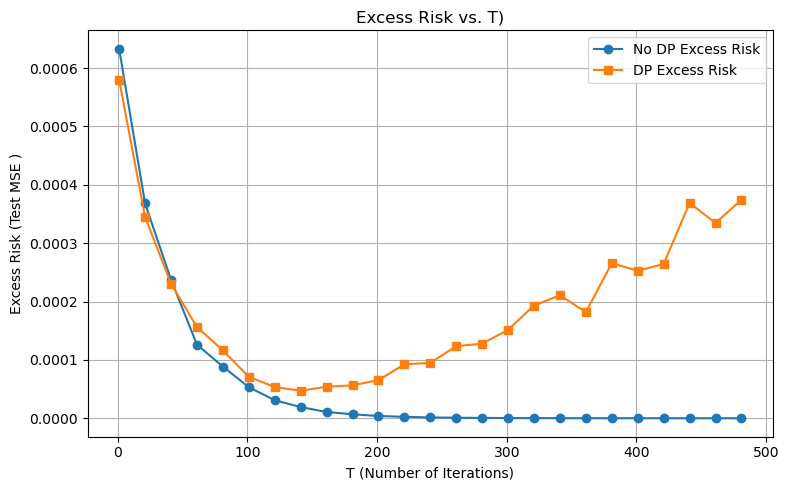

In [5]:
def run_experiment(D, T_values):
    """
    For each T value, train Algorithm 2 (both DP and non-DP) on a fixed training set,
    compute the local ridge oracle (using ridge regression on the training summary statistics)
    and then compute the excess risk (test MSE difference) between Algorithm 2 and the local ridge oracle.
    
    Returns:
      - no_dp_excess_risk: list of excess risks (non-DP) for each T.
      - dp_excess_risk: list of excess risks (DP) for each T.
    """
    # Parameters that depend on N, L, and D.
    lam =  N/D     # Regularization parameter for both Algorithm 2 and ridge oracle.
    C = np.sqrt(2 * np.log(N * L))
    R = (1 / lam) * (C ** 2) * np.sqrt(N / L)
    G = (C / np.sqrt(L)) * (1 + (np.log(N) / (D ** 2)) ** (1 / 4))
    eta0 = 0.01*(2 * lam / (3 * ((lam + G ** 2) ** 2)))
    
    print(f"1-eta0*lambda = {(1-eta0*lam)}")
    print(f"N = {N}")
    print(f"L = {L}")
    print(f"D = {D}")
    print(f"C = {C}")
    print(f"R = {R}")
    print(f"G = {G}")
    print(f"sigma={2.0 * G * (C + R * G)}")
    print(f"lambda = {lam}")
    print(f"step-size = {eta0}")
    
    no_dp_excess_risk = []
    dp_excess_risk = []
    
    for T in tqdm(T_values, desc="Training", ncols=100, position=0):
        # Build the training dataset.
        xs_train, xq_train, ys_train, yq_train = build_dataset(N, D, L)
        # Build a test dataset.
        N_test = 500
        xs_test, xq_test, ys_test, yq_test = build_dataset(N_test, D, L)
        
        # Train Algorithm 2 (non-DP) on the same training data.
        losses_no_dp, Gamma_no_dp, Ztilde_ls, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=False
        )
        # Train Algorithm 2 (DP) on the same training data.
        losses_dp, Gamma_dp, _, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=True
        )
        
        # --- Compute the local ridge oracle on the training set ---
        # Reshape the summary statistics from non-DP training.
        N_train = N
        d1, d2 = Ztilde_ls.shape[1:3]
        D_total = d1 * d2
        Zmat = Ztilde_ls.reshape(N_train, D_total)
        ridge_lam = lam  # Use the same regularization parameter.
        A = (N_train * ridge_lam) * np.eye(D_total) + Zmat.T @ Zmat
        b = Zmat.T @ yq_train
        L_chol = np.linalg.cholesky(A)
        v = np.linalg.solve(L_chol, b)
        gamma_vec = np.linalg.solve(L_chol.T, v)
        Gamma_star = gamma_vec.reshape(d1, d2)
        
        # --- Compute test predictions ---
        Z_test_all = compute_Ztilde_vectorized(xq_test, xs_test, ys_test, L, G, C, dp_enabled=False)
        # Local ridge predictions.
        y_hat_ridge = np.sum(Gamma_star * Z_test_all, axis=(1,2))
        mse_ridge = np.mean((y_hat_ridge - yq_test)**2)
        
        # Algorithm 2 predictions.
        #Z_tilde_test = compute_Ztilde(xq_test[k], xs_test[k], ys_test[k],
                                          #L, G, C, dp_enabled=True)
        #y_hat_no_dp = np.sum(Gamma_no_noise * Z_tilde_test)
        #y_hat_dp    = np.sum(Gamma_dp      * Z_tilde_test)
        y_hat_no_dp = np.sum(Gamma_no_dp * Z_test_all, axis=(1,2))
        mse_no_dp = np.mean((y_hat_no_dp - y_hat_ridge)**2)
        
        y_hat_dp = np.sum(Gamma_dp * Z_test_all, axis=(1,2))
        mse_dp = np.mean((y_hat_dp - y_hat_ridge)**2)
        
        # Compute excess risk as the difference from the local ridge oracle.
        excess_risk_no_dp = mse_no_dp # - mse_ridge
        excess_risk_dp = mse_dp #- mse_ridge
        
        no_dp_excess_risk.append(excess_risk_no_dp)
        dp_excess_risk.append(excess_risk_dp)
        
    return no_dp_excess_risk, dp_excess_risk

# Define T values: 1, 20, ..., 100.
T_values = list(range(1, 500, 20))

######################################
# Run Experiments for Two Settings of D
######################################
# Case 1: D = 5
#no_dp_excess_D5, dp_excess_D5 = run_experiment(5, T_values)
# Case 2: D ≈ √N;
#no_dp_excess_D32, dp_excess_D32 = run_experiment(int(1*np.sqrt(N)), T_values)

######################################
# Plotting the Results
######################################
# Plot for D = 5.
#plt.figure(figsize=(8, 5))
#plt.plot(T_values, no_dp_excess_D5, 'o-', label="No DP Excess Risk")
#plt.plot(T_values, dp_excess_D5, 's-', label="DP Excess Risk")
#plt.xlabel("T (Number of Iterations)")
#plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
#plt.title("Excess Risk vs. T (D = 5, N = 8000, ε = 0.05)")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Parallellized

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np

# Set consistent seed
np.random.seed(1609)

# Config
n_simulations = 500
n_jobs = 4
T_values = list(range(1, 500, 20))  # Keep T_values as in your original code

# Wrapper to run a single simulation with seed control
def single_run(seed, D, T_values):
    np.random.seed(seed)
    return run_experiment(D, T_values)

# Wrapper to run n_simulations and return average results in (D): (no_dp_avg, dp_avg) format
def run_experiment_wrapper(D):
    seeds = range(n_simulations)
    with tqdm_joblib(tqdm(desc=f"Running {n_simulations} simulations for D={D}", total=n_simulations, ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_run)(seed, D, T_values) for seed in seeds
        )

    # Average results across simulations
    no_dp_all = np.array([r[0] for r in results])
    dp_all = np.array([r[1] for r in results])
    no_dp_mean = np.mean(no_dp_all, axis=0)
    dp_mean = np.mean(dp_all, axis=0)
    return D, (no_dp_mean, dp_mean)

# Run one experiment (you can scale this for multiple D if needed)
results = [run_experiment_wrapper(int(1*np.sqrt(N)))]

# Collect into a dictionary
results_dict = dict(results)

# Example: plotting the results
avg_no_dp_excess, avg_dp_excess = results_dict[int(1*np.sqrt(N))]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(T_values, avg_no_dp_excess, 'o-', label="Avg No DP Excess Risk")
plt.plot(T_values, avg_dp_excess, 's-', label="Avg DP Excess Risk")
plt.xlabel("T (Number of Iterations)")
plt.ylabel("Average Excess Risk (Test MSE)")
plt.title(f"Average Excess Risk vs. T (D={int(1*np.sqrt(N))}, N=1000, ε=0.8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Finer phase transition plot

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


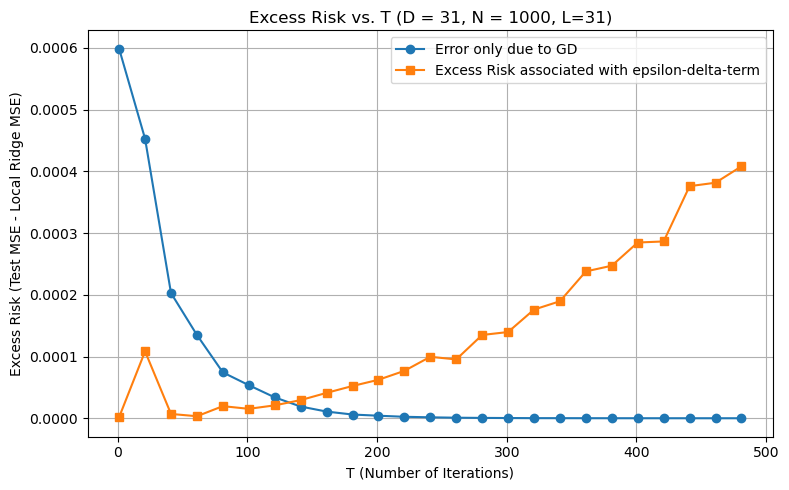

In [6]:
## decompose DP error =GD error+ extra error solely due to privacy

def run_experiment_decomp(D, T_values):
    """
    For each T value, train Algorithm 2 (both DP and non-DP) on a fixed training set,
    compute the local ridge oracle (using ridge regression on the training summary statistics)
    and then compute the excess risk (test MSE difference) between Algorithm 2 and the local ridge oracle.
    
    Returns:
      - no_dp_excess_risk: list of excess risks (non-DP) for each T.
      - dp_excess_risk: list of excess risks (DP) for each T.
    """
    # Parameters that depend on N, L, and D.
    lam = N/D  # Regularization parameter for both Algorithm 2 and ridge oracle.
    C = np.sqrt(2 * np.log(N * L))
    R = (1 / lam) * (C ** 2) * np.sqrt(N / L)
    G = (C / np.sqrt(L)) * (1 + (np.log(N) / (D ** 2)) ** (1 / 4))
    eta0 = 0.01*(2 * lam / (3 * ((lam + G ** 2) ** 2)))
    
    print(f"1-eta0*lambda = {(1-eta0*lam)}")
    print(f"N = {N}")
    print(f"L = {L}")
    print(f"D = {D}")
    print(f"C = {C}")
    print(f"R = {R}")
    print(f"G = {G}")
    print(f"sigma={2.0 * G * (C + R * G)}")
    print(f"lambda = {lam}")
    print(f"step-size = {eta0}")
    
    no_dp_excess_risk = []
    dp_excess_risk = []
    
    for T in tqdm(T_values, desc="Training", ncols=100, position=0):
        # Build the training dataset.
        xs_train, xq_train, ys_train, yq_train = build_dataset(N, D, L)
        # Build a test dataset.
        N_test = 500
        xs_test, xq_test, ys_test, yq_test = build_dataset(N_test, D, L)
        
        # Train Algorithm 2 (non-DP) on the same training data.
        losses_no_dp, Gamma_no_dp, Ztilde_ls, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=False
        )
        # Train Algorithm 2 (DP) on the same training data.
        losses_dp, Gamma_dp, _, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=True
        )
        
        # --- Compute the local ridge oracle on the training set ---
        # Reshape the summary statistics from non-DP training.
        N_train = N
        d1, d2 = Ztilde_ls.shape[1:3]
        D_total = d1 * d2
        Zmat = Ztilde_ls.reshape(N_train, D_total)
        ridge_lam = lam  # Use the same regularization parameter.
        A = (N_train * ridge_lam) * np.eye(D_total) + Zmat.T @ Zmat
        b = Zmat.T @ yq_train
        L_chol = np.linalg.cholesky(A)
        v = np.linalg.solve(L_chol, b)
        gamma_vec = np.linalg.solve(L_chol.T, v)
        Gamma_star = gamma_vec.reshape(d1, d2)
        
        # --- Compute test predictions ---
        Z_test_all = compute_Ztilde_vectorized(xq_test, xs_test, ys_test, L, G, C, dp_enabled=False)
        # Local ridge predictions.
        y_hat_ridge = np.sum(Gamma_star * Z_test_all, axis=(1,2))
        mse_ridge = np.mean((y_hat_ridge - yq_test)**2)
        
        # Algorithm 2 predictions.
        #Z_tilde_test = compute_Ztilde(xq_test[k], xs_test[k], ys_test[k],
                                          #L, G, C, dp_enabled=True)
        #y_hat_no_dp = np.sum(Gamma_no_noise * Z_tilde_test)
        #y_hat_dp    = np.sum(Gamma_dp      * Z_tilde_test)
        y_hat_no_dp = np.sum(Gamma_no_dp * Z_test_all, axis=(1,2))
        mse_no_dp = np.mean((y_hat_no_dp - y_hat_ridge)**2)
        
        y_hat_dp = np.sum(Gamma_dp * Z_test_all, axis=(1,2))
        mse_dp = np.mean((y_hat_dp - y_hat_ridge)**2)
        
        # Compute excess risk as the difference from the local ridge oracle.
        excess_risk_no_dp = mse_no_dp # find the error only due to DP term.
        excess_risk_dp = abs(mse_dp - mse_no_dp) # find the error only due to DP term.
        
        no_dp_excess_risk.append(excess_risk_no_dp)
        dp_excess_risk.append(excess_risk_dp)
        
    return no_dp_excess_risk, dp_excess_risk

# Define T values: 1, 20, ..., 100.
T_values = list(range(1, 500, 20))

######################################
# Run Experiments for Two Settings of D
######################################
# Case 1: D = 5
#no_dp_excess_D5, dp_excess_D5 = run_experiment(5, T_values)
# Case 2: D ≈ √N;
#no_dp_excess_D32, dp_excess_D32 = run_experiment_decomp(int(1*N**0.5), T_values)

######################################
# Plotting the Results
######################################
# Plot for D = 5.
#plt.figure(figsize=(8, 5))
#plt.plot(T_values, no_dp_excess_D5, 'o-', label="No DP Excess Risk")
#plt.plot(T_values, dp_excess_D5, 's-', label="DP Excess Risk")
#plt.xlabel("T (Number of Iterations)")
#plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
#plt.title("Excess Risk vs. T (D = 5, N = 8000, ε = 0.05)")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Plot for D = sqrt(N).



In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for consistency
np.random.seed(1609)

# Constants
n_simulations = 500
n_jobs = 4
T_values = list(range(1, 500, 20))
D = int(1 * N**0.5)  # Do not change

# Single run wrapper with seeding
def single_run_decomp(seed, D, T_values):
    np.random.seed(seed)
    return run_experiment_decomp(D, T_values)

# Wrapper to run multiple simulations and return (D): (GD_error, DP_extra_error)
def run_experiment_decomp_wrapper(D):
    seeds = range(n_simulations)
    with tqdm_joblib(tqdm(desc=f"Running {n_simulations} decomposed sims for D={D}", total=n_simulations, ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_run_decomp)(seed, D, T_values) for seed in seeds
        )

    # Average results across simulations
    no_dp_all = np.array([res[0] for res in results])
    dp_all = np.array([res[1] for res in results])
    no_dp_mean = np.mean(no_dp_all, axis=0)
    dp_mean = np.mean(dp_all, axis=0)
    return D, (no_dp_mean, dp_mean)

# Run the simulation
results = [run_experiment_decomp_wrapper(D)]

# Unpack results
results_dict = dict(results)
avg_gd_error, avg_dp_extra_error = results_dict[D]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(T_values, avg_gd_error, 'o-', label="Error only due to GD")
plt.plot(T_values, avg_dp_extra_error, 's-', label="Excess Risk associated with ε-δ term")
plt.xlabel("T (Number of Iterations)")
plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
plt.title("Excess Risk vs. T (D = √N, N = 8000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
